# Reddit Comments Sentiment Analysis

contributors:
Sahar & Nahid

 my github link: (https://github.com/saharhekmatdoust)
 ## Final Results:
|model|accuracy|
|-----|--------|
|Random Forest|0.816|
|FCN|0.69|
|FCN with dropout|0.754|
|LSTM|0.427|
|LSTM Bidirectional|0.746|
|GRU|0.427|
|keras_tuner on FCNN|0.836|




## Problem Definition: 
In the previous semester we classified text  with traditional ML algorithms and for this semester, we would like to compare Deep learning models to traditional ML models for text classification. So we will set up the baseline with a Random Forest model and compare that to different Deep Learning models like FCNN,RNN, LSTM & GRU. We will also compare different hyperparameters and  model architectures of our deep learning models. We will be using Keras Tuner to tune the hyperparameters and then use tensorboard to compare the results.

In [241]:
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

from keras.preprocessing.text import one_hot
# from keras.utils import pad_sequences
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN, Flatten, Embedding, Bidirectional, Dropout
from keras.preprocessing.text import Tokenizer
from keras.regularizers import l2
import tensorflow as tf


## Dataset:
We want to work with a [Reddit Sentimental analysis](https://www.kaggle.com/datasets/cosmos98/twitter-and-reddit-sentimental-analysis-dataset?select=Reddit_Data.csv) dataset available on kaggle. The dataset contains 37K Comments along with its Sentimental Label (Positive-Negative-Neutral). The Dataset has two columns, the first column has the cleaned comments and the second one indicates its Sentimental Label.

### READ DATA

In [242]:
reddit_comments = pd.read_csv('./data/Reddit_Data.csv')
reddit_comments.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


## Methodology:

**Data Preprocessing:** This involves cleaning and normalizing the text, such as converting to lowercase, removing stop words, stemming or lemmatizing, etc.

**Feature extraction:** This step involves converting the preprocessed text into numerical features that the models can learn from- such as using text vectoriaztion.

**Model architecture:** For this section we decided to try both traditional machine learning methods(Random forest) and deep learning methods (FCN-LSTM-RNN-GRU) and make a benchmark algorithm to compare different models and identify the best one. We will try different neural networks with different number of layers  and different the number of neurons in each layer and then try other hyperparameters as well. 

**Hyperparameter tuning:** The process of hyperparameter tuning involves running the algorithm multiple times with different hyperparameter values and selecting the best combination that results in the best performance. For this purpose, we want to try different numbers of dropout layers, regularizations and optimizers.

### EDA

In [243]:
reddit_comments.shape

(37249, 2)

In [244]:
reddit_comments.isna().sum()

clean_comment    100
category           0
dtype: int64

In [245]:
reddit_comments.dropna(axis=0, inplace=True)
reddit_comments.reset_index(drop=True, inplace=True)
reddit_comments.isna().sum()

clean_comment    0
category         0
dtype: int64

In [246]:
reddit_comments

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1
...,...,...
37144,jesus,0
37145,kya bhai pure saal chutiya banaya modi aur jab...,1
37146,downvote karna tha par upvote hogaya,0
37147,haha nice,1


In [247]:
reddit_comments['category'].value_counts()

 1    15830
 0    13042
-1     8277
Name: category, dtype: int64

In [248]:
reddit_comments["clean_comment"][0]

' family mormon have never tried explain them they still stare puzzled from time time like some kind strange creature nonetheless they have come admire for the patience calmness equanimity acceptance and compassion have developed all the things buddhism teaches '

<AxesSubplot:xlabel='category', ylabel='count'>

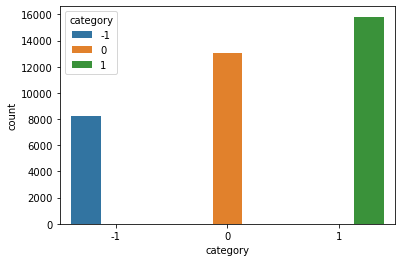

In [249]:
sns.countplot(x='category', data=reddit_comments, hue="category")

### PREPROCESSING

In [250]:
nltk.download('stopwords')
stop_words = stopwords.words('english') #English language's stop words

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [251]:
def textpreprocess(s):
    words = []
    
    s = s.strip().lower() # lower the string
    s = re.sub('\[.*?\]', '', s) # removes symbols (.*?\)
    s = re.sub('https?://\S+|www\.\S+', '', s) # remove URLS
    s = re.sub('<.*?>+', '', s)
    s = re.sub('[%s]' % re.escape(string.punctuation), '', s) # remove punctuations
    s = re.sub('\n', '', s) # remove next line character
    s = re.sub('\w*\d\w*', '', s)
    
    words = s.split() # split the string into list of words
    words = [word for word in words if word not in stop_words] # removing stop words
    s = ' '.join(words) # converting list to string
    
    return s

In [252]:
for i in range(reddit_comments.shape[0]):
    reddit_comments.at[i,'clean_comment'] = textpreprocess(reddit_comments.at[i,'clean_comment'])

In [253]:
reddit_comments

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal wrappi...,0
4,benefit may want read living buddha living chr...,1
...,...,...
37144,jesus,0
37145,kya bhai pure saal chutiya banaya modi aur jab...,1
37146,downvote karna tha par upvote hogaya,0
37147,haha nice,1


### HELPER FUNCTIONS

In [254]:
algo_accuracies = {}

def append_accuracy(model, test_acc):        
    algo_accuracies[model] = round(np.mean(test_acc), 2)

### Model Evaluation
#### BASELINE MODEL (RandomForest)

In [255]:
tfidf = TfidfVectorizer(max_features=15000)
X_tfidf = tfidf.fit_transform(reddit_comments['clean_comment'].values)
X_tfidf

<37149x15000 sparse matrix of type '<class 'numpy.float64'>'
	with 561809 stored elements in Compressed Sparse Row format>

In [256]:
reddit_comments['category'] = reddit_comments['category'].replace(-1,2)
y = reddit_comments['category']

In [257]:
X_tfidf_train, X_tfidf_test, y_train, y_test=train_test_split(X_tfidf, y, test_size=0.2)

In [258]:
print(f'X_tfidf_train shape: {X_tfidf_train.shape}')
print(f'X_tfidf_test shape: {X_tfidf_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_tfidf_train shape: (29719, 15000)
X_tfidf_test shape: (7430, 15000)
y_train shape: (29719,)
y_test shape: (7430,)


In [259]:
rf_clf = RandomForestClassifier(random_state=25).fit(X_tfidf_train, y_train)
rf_predictions = rf_clf.predict(X_tfidf_test)

In [260]:
rf_accuracy = accuracy_score(y_test, rf_predictions)
append_accuracy("RandomForest", rf_accuracy)
rf_accuracy

0.8168236877523554

**Note: We will set the RandomForest model accuracy as the baseline and try to implement NN models to
see how they compare with this base line.**

### DEEP LEARNING MODELS EVALUATION

We will train FCN, LSTM & GRU models to test how how they perform. And also we will create a GloVe embedding layer for embedding the inputs instead of the TFIDF vectorizer. 

In [261]:
clean_comments = []
sentences = list(reddit_comments['clean_comment'])
for sen in sentences:
    text = textpreprocess(sen)
    clean_comments.append(text)

In [262]:
X_train, X_test, y_train, y_test = train_test_split(clean_comments, y, test_size=0.20, random_state=42)

In [263]:
print(f'X_train size: {len(X_train)}')
print(f'X_test size: {len(X_test)}')
print(f'y_train size: {len(y_train)}')
print(f'y_test size: {len(y_test)}')

X_train size: 29719
X_test size: 7430
y_train size: 29719
y_test size: 7430


In [264]:
X_train[10]

'super depressing see vendors make raid armor obsolete soon dlc drops'

In [265]:
y_train[0]

1

### Use Tokenizer to integer encode the comments

In [266]:
num_words_ = 5000
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=num_words_, oov_token=oov_tok)
tokenizer.fit_on_texts(clean_comments)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [267]:
# sanity check
tokenized=tokenizer.texts_to_sequences(['life is good'])
tokenized

[[141, 1, 8]]

In [268]:
(X_train[0])

[1, 276, 666, 7, 1751, 883, 4098, 3019, 53, 1, 259, 1]

In [269]:
len(tokenizer.word_index)

52468

### Pad Sequences to create equal-length inputs

In [270]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 500
trunc_type='post'
padding_type='post'

X_train = pad_sequences(X_train, maxlen=maxlen, truncating= trunc_type, padding=padding_type)
X_test = pad_sequences(X_test, padding=padding_type, maxlen=maxlen, truncating= trunc_type)

In [271]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (29719, 500)
X_test shape: (7430, 500)


 For GloVe Embedding we used the [glove.6B.50d.txt(175 MB)](https://www.kaggle.com/datasets/watts2/glove6b50dtxt) dataset. But due to large file size it is not included in the repository.
please download it if you want to run the notebook.

In [272]:
embeddings_dictionary = dict()
glove_file = open('./glove.6B.50d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [273]:
# check sample
embeddings_dictionary["life"]

array([ 0.51491 ,  0.88806 , -0.71906 , -0.5748  ,  0.85655 ,  0.52474 ,
       -0.31788 , -0.20168 ,  0.17936 ,  0.51999 , -0.11527 ,  0.59296 ,
       -0.3468  ,  0.052568,  0.87153 , -0.036582, -0.056057,  0.08516 ,
        0.036249,  0.23403 ,  0.073175,  1.1394  , -0.17921 , -0.034245,
        0.69977 , -1.6516  , -1.106   , -0.44145 ,  0.77042 ,  0.23963 ,
        3.1823  , -0.020451, -0.056117, -0.69918 , -0.19543 ,  0.19492 ,
       -0.36403 ,  0.053196,  0.26225 , -0.29054 , -0.64883 , -0.057846,
        0.21646 ,  0.40237 , -0.1413  , -0.015453, -0.11988 , -0.99837 ,
       -0.066328,  0.13118 ], dtype=float32)

### Embedding matrix for the inputs

In [274]:
embedding_matrix = np.zeros((vocab_size, 50))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

#### FCNN

In [275]:
fcn_model = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
fcn_model.add(embedding_layer)
fcn_model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001)))
fcn_model.add(Flatten())
fcn_model.add(Dense(3, activation='softmax'))

fcn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(fcn_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 50)           2623450   
_________________________________________________________________
dense_4 (Dense)              (None, 500, 32)           1632      
_________________________________________________________________
flatten_1 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 48003     
Total params: 2,673,085
Trainable params: 49,635
Non-trainable params: 2,623,450
_________________________________________________________________
None


In [276]:
fcn_history = fcn_model.fit(X_train, y_train, batch_size=1000, epochs=30, verbose=1, validation_split=0.2)

Epoch 1/30
47/47 [==============================] - 1s 12ms/step - loss: 0.9443 - accuracy: 0.5533 - val_loss: 0.8700 - val_accuracy: 0.6060
Epoch 2/30
47/47 [==============================] - 0s 8ms/step - loss: 0.8421 - accuracy: 0.6136 - val_loss: 0.8221 - val_accuracy: 0.6255
Epoch 3/30
47/47 [==============================] - 0s 9ms/step - loss: 0.7926 - accuracy: 0.6482 - val_loss: 0.7979 - val_accuracy: 0.6449
Epoch 4/30
47/47 [==============================] - 0s 8ms/step - loss: 0.7640 - accuracy: 0.6664 - val_loss: 0.7863 - val_accuracy: 0.6512
Epoch 5/30
47/47 [==============================] - 0s 7ms/step - loss: 0.7443 - accuracy: 0.6777 - val_loss: 0.7770 - val_accuracy: 0.6548
Epoch 6/30
47/47 [==============================] - 0s 7ms/step - loss: 0.7287 - accuracy: 0.6890 - val_loss: 0.7746 - val_accuracy: 0.6608
Epoch 7/30
47/47 [==============================] - 0s 7ms/step - loss: 0.7170 - accuracy: 0.6931 - val_loss: 0.7724 - val_accuracy: 0.6625
Epoch 8/30
47/47 [=

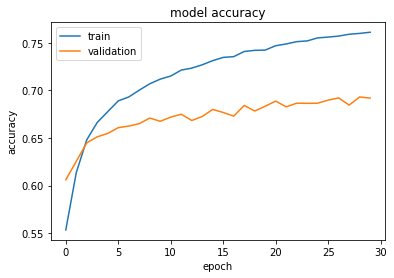

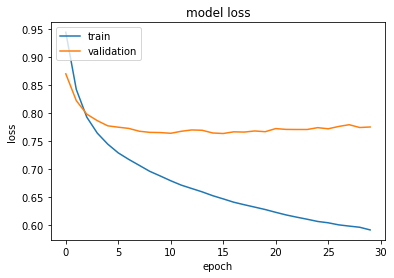

In [277]:
plt.plot(fcn_history.history['accuracy'])
plt.plot(fcn_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(fcn_history.history['loss'])
plt.plot(fcn_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [278]:
score = fcn_model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

append_accuracy("FCN", score[1])

233/233 [==============================] - 1s 2ms/step - loss: 0.7613 - accuracy: 0.6964
Test Loss: 0.7613192796707153
Test Accuracy: 0.6963660717010498


We can clearly see that the model did not perform well for the validation and test set. This is happening because there might be overfitting. So there is high variance. We can address this problem by introducing dropout layers. 

In [279]:
fcn_model = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
fcn_model.add(embedding_layer)
fcn_model.add(Dropout(0.3))
fcn_model.add(Dense(128, activation='relu'))
fcn_model.add(Dropout(0.3))
fcn_model.add(Dense(128, activation='relu'))
fcn_model.add(Dropout(0.3))
fcn_model.add(Dense(64, activation='relu'))
fcn_model.add(Dropout(0.3))
fcn_model.add(Flatten())
fcn_model.add(Dense(3, activation='softmax'))

fcn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(fcn_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 50)           2623450   
_________________________________________________________________
dropout_4 (Dropout)          (None, 500, 50)           0         
_________________________________________________________________
dense_6 (Dense)              (None, 500, 128)          6528      
_________________________________________________________________
dropout_5 (Dropout)          (None, 500, 128)          0         
_________________________________________________________________
dense_7 (Dense)              (None, 500, 128)          16512     
_________________________________________________________________
dropout_6 (Dropout)          (None, 500, 128)          0         
_________________________________________________________________
dense_8 (Dense)              (None, 500, 64)          

In [280]:
fcn_history = fcn_model.fit(X_train, y_train, batch_size=1000, epochs=30, verbose=1, validation_split=0.2)

Epoch 1/30
47/47 [==============================] - 3s 58ms/step - loss: 0.9428 - accuracy: 0.5555 - val_loss: 0.9211 - val_accuracy: 0.5752
Epoch 2/30
47/47 [==============================] - 2s 52ms/step - loss: 0.8751 - accuracy: 0.6008 - val_loss: 0.8703 - val_accuracy: 0.5949
Epoch 3/30
47/47 [==============================] - 2s 52ms/step - loss: 0.8287 - accuracy: 0.6294 - val_loss: 0.7930 - val_accuracy: 0.6491
Epoch 4/30
47/47 [==============================] - 2s 52ms/step - loss: 0.8027 - accuracy: 0.6447 - val_loss: 0.7924 - val_accuracy: 0.6400
Epoch 5/30
47/47 [==============================] - 3s 54ms/step - loss: 0.7842 - accuracy: 0.6582 - val_loss: 0.7502 - val_accuracy: 0.6713
Epoch 6/30
47/47 [==============================] - 3s 55ms/step - loss: 0.7706 - accuracy: 0.6654 - val_loss: 0.7620 - val_accuracy: 0.6625
Epoch 7/30
47/47 [==============================] - 2s 53ms/step - loss: 0.7661 - accuracy: 0.6689 - val_loss: 0.7642 - val_accuracy: 0.6635
Epoch 8/30
47

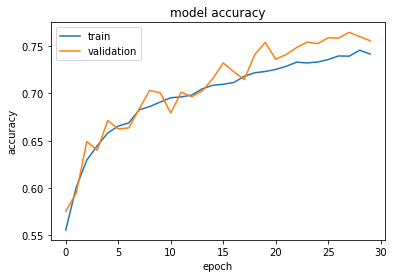

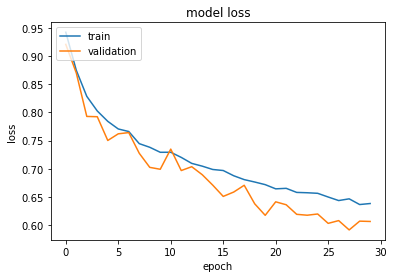

In [281]:
plt.plot(fcn_history.history['accuracy'])
plt.plot(fcn_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(fcn_history.history['loss'])
plt.plot(fcn_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [282]:
score = fcn_model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

append_accuracy("FCN Dropout", score[1])

233/233 [==============================] - 1s 4ms/step - loss: 0.6214 - accuracy: 0.7546
Test Loss: 0.6213506460189819
Test Accuracy: 0.7546433210372925


### LSTM

In [283]:
lstm_model=Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128,activation='tanh',return_sequences=True, kernel_regularizer=l2(0.0001)))
lstm_model.add(LSTM(32,activation='tanh'))
lstm_model.add(Dense(32,activation='sigmoid'))
lstm_model.add(Dense(3,activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
lstm_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(lstm_model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 50)           2623450   
_________________________________________________________________
lstm (LSTM)                  (None, 500, 128)          91648     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 99        
Total params: 2,736,861
Trainable params: 113,411
Non-trainable params: 2,623,450
_________________________________________________________________
None


In [284]:
lstm_history = lstm_model.fit(X_train, y_train, batch_size=1000, epochs=30, verbose=1, validation_split=0.2)

Epoch 1/30
47/47 [==============================] - 9s 125ms/step - loss: 1.1573 - accuracy: 0.2591 - val_loss: 1.1225 - val_accuracy: 0.3452
Epoch 2/30
47/47 [==============================] - 5s 114ms/step - loss: 1.0812 - accuracy: 0.4100 - val_loss: 1.0684 - val_accuracy: 0.4383
Epoch 3/30
47/47 [==============================] - 5s 114ms/step - loss: 1.0748 - accuracy: 0.4225 - val_loss: 1.0668 - val_accuracy: 0.4383
Epoch 4/30
47/47 [==============================] - 5s 115ms/step - loss: 1.0739 - accuracy: 0.4226 - val_loss: 1.0659 - val_accuracy: 0.4384
Epoch 5/30
47/47 [==============================] - 5s 116ms/step - loss: 1.0732 - accuracy: 0.4226 - val_loss: 1.0659 - val_accuracy: 0.4384
Epoch 6/30
47/47 [==============================] - 5s 117ms/step - loss: 1.0727 - accuracy: 0.4227 - val_loss: 1.0648 - val_accuracy: 0.4384
Epoch 7/30
47/47 [==============================] - 5s 115ms/step - loss: 1.0721 - accuracy: 0.4227 - val_loss: 1.0649 - val_accuracy: 0.4384
Epoch 

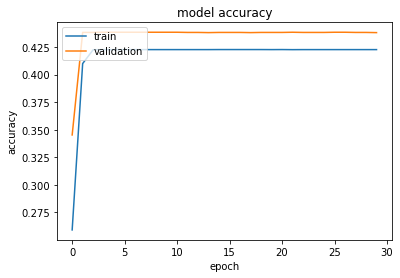

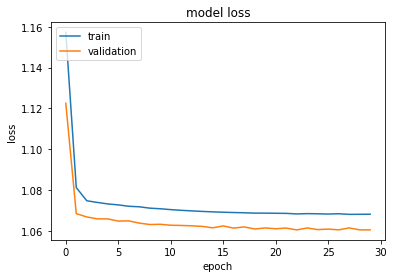

In [285]:
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [286]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

append_accuracy("LSTM", score[1])

233/233 [==============================] - 4s 19ms/step - loss: 1.0617 - accuracy: 0.4279
Test Loss: 1.061693549156189
Test Accuracy: 0.4278600215911865


**Bidirectional LSTM.**

In [287]:
lstm_model=Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
lstm_model.add(embedding_layer)
lstm_model.add(Bidirectional(LSTM(32, kernel_regularizer=l2(0.0001))))
lstm_model.add(Dense(32,activation='relu'))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(3,activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
lstm_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(lstm_model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 50)           2623450   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                21248     
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 99        
Total params: 2,646,877
Trainable params: 23,427
Non-trainable params: 2,623,450
_________________________________________________________________
None


In [288]:
lstm_history = lstm_model.fit(X_train, y_train, batch_size=1000, epochs=30, verbose=1, validation_split=0.2)

Epoch 1/30
47/47 [==============================] - 5s 69ms/step - loss: 1.0169 - accuracy: 0.5065 - val_loss: 0.8797 - val_accuracy: 0.6018
Epoch 2/30
47/47 [==============================] - 3s 60ms/step - loss: 0.8481 - accuracy: 0.6204 - val_loss: 0.8026 - val_accuracy: 0.6420
Epoch 3/30
47/47 [==============================] - 3s 54ms/step - loss: 0.7958 - accuracy: 0.6536 - val_loss: 0.7695 - val_accuracy: 0.6566
Epoch 4/30
47/47 [==============================] - 3s 55ms/step - loss: 0.7680 - accuracy: 0.6675 - val_loss: 0.7491 - val_accuracy: 0.6667
Epoch 5/30
47/47 [==============================] - 3s 54ms/step - loss: 0.7488 - accuracy: 0.6763 - val_loss: 0.7326 - val_accuracy: 0.6748
Epoch 6/30
47/47 [==============================] - 3s 58ms/step - loss: 0.7353 - accuracy: 0.6851 - val_loss: 0.7289 - val_accuracy: 0.6881
Epoch 7/30
47/47 [==============================] - 3s 66ms/step - loss: 0.7211 - accuracy: 0.6942 - val_loss: 0.7149 - val_accuracy: 0.6911
Epoch 8/30
47

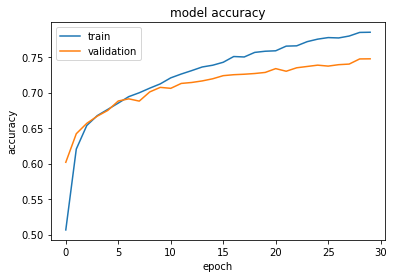

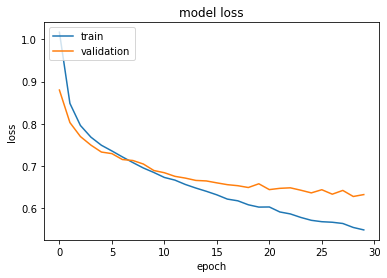

In [289]:
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [290]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

append_accuracy("LSTM Bidirectional", score[1])

233/233 [==============================] - 4s 17ms/step - loss: 0.6340 - accuracy: 0.7468
Test Loss: 0.6339795589447021
Test Accuracy: 0.7468371391296387


### GRU

In [291]:
gru_model=Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
gru_model.add(embedding_layer)
gru_model.add(GRU(128,activation='tanh',return_sequences=True, kernel_regularizer=l2(0.0001)))
gru_model.add(GRU(32,activation='tanh'))
gru_model.add(Dense(32,activation='sigmoid', bias_regularizer=l2(0.0001)))
gru_model.add(Dense(3,activation='softmax'))


opt = tf.keras.optimizers.Adam(learning_rate=0.001)
gru_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(gru_model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 50)           2623450   
_________________________________________________________________
gru (GRU)                    (None, 500, 128)          69120     
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                15552     
_________________________________________________________________
dense_14 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 99        
Total params: 2,709,277
Trainable params: 85,827
Non-trainable params: 2,623,450
_________________________________________________________________
None


In [292]:
gru_history = gru_model.fit(X_train, y_train, batch_size=1000, epochs=30, verbose=1, validation_split=0.2)

Epoch 1/30
47/47 [==============================] - 7s 112ms/step - loss: 1.0785 - accuracy: 0.4089 - val_loss: 1.0631 - val_accuracy: 0.4383
Epoch 2/30
47/47 [==============================] - 5s 100ms/step - loss: 1.0694 - accuracy: 0.4225 - val_loss: 1.0612 - val_accuracy: 0.4383
Epoch 3/30
47/47 [==============================] - 5s 100ms/step - loss: 1.0684 - accuracy: 0.4225 - val_loss: 1.0615 - val_accuracy: 0.4383
Epoch 4/30
47/47 [==============================] - 5s 100ms/step - loss: 1.0683 - accuracy: 0.4225 - val_loss: 1.0602 - val_accuracy: 0.4383
Epoch 5/30
47/47 [==============================] - 5s 100ms/step - loss: 1.0681 - accuracy: 0.4225 - val_loss: 1.0600 - val_accuracy: 0.4383
Epoch 6/30
47/47 [==============================] - 5s 104ms/step - loss: 1.0680 - accuracy: 0.4225 - val_loss: 1.0604 - val_accuracy: 0.4383
Epoch 7/30
47/47 [==============================] - 5s 101ms/step - loss: 1.0682 - accuracy: 0.4225 - val_loss: 1.0600 - val_accuracy: 0.4383
Epoch 

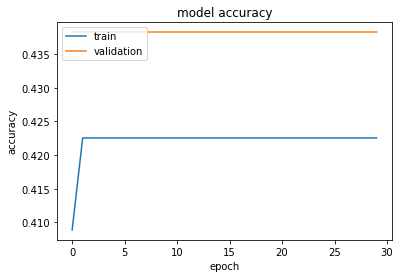

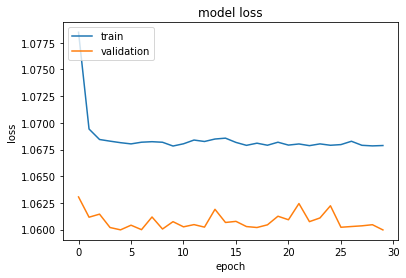

In [293]:
plt.plot(gru_history.history['accuracy'])
plt.plot(gru_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(gru_history.history['loss'])
plt.plot(gru_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [294]:
score = gru_model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

append_accuracy("GRU", score[1])

233/233 [==============================] - 3s 13ms/step - loss: 1.0616 - accuracy: 0.4279
Test Loss: 1.0615659952163696
Test Accuracy: 0.4278600215911865


## Results for different methods:

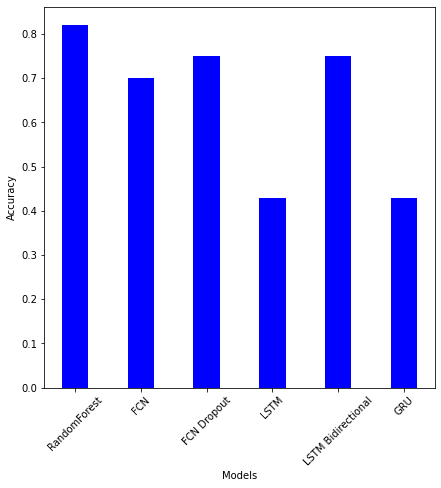

In [295]:
# plot the result
clsf = list(algo_accuracies.keys())
result = list(algo_accuracies.values())
  
fig = plt.figure(figsize = (7, 7))

plt.bar(clsf, result, color ='blue', width = 0.4)
plt.xticks(range(len(clsf)), clsf, rotation=45)
 
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.show()

### Hyperparameter Tuning for the best model (FCNN with Dropout)

***We got the best accuracy 0.75 with FCNN with dropout model. Now we will tune hyperparameters for
this model and see the impact on performance.***

In [296]:
def build_model(hp):
    fcn_model = Sequential()
    embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
    fcn_model.add(embedding_layer)
    fcn_model.add(Dropout(hp.Float('dropout_rate',min_value=0.2,max_value=0.4,step=0.2)))
    fcn_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001)))
    fcn_model.add(Dropout(hp.Float('dropout_rate',min_value=0.2,max_value=0.4,step=0.2)))
    fcn_model.add(Dense(hp.Choice('units', [64, 128]), activation='relu'))
    fcn_model.add(Dropout(hp.Float('dropout_rate',min_value=0.2,max_value=0.4,step=0.2)))
    fcn_model.add(Dense(hp.Choice('units', [32, 64]), activation='relu'))
    fcn_model.add(Dropout(hp.Float('dropout_rate',min_value=0.2,max_value=0.4,step=0.2)))
    fcn_model.add(Flatten())
    fcn_model.add(Dense(3, activation='softmax'))

    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    fcn_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return fcn_model

In [297]:
import keras_tuner as kt
from keras.callbacks import EarlyStopping, TensorBoard

In [298]:
tuner= kt.RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=10,
        directory="/kaggle/working/tmp/tb",
        overwrite=True,
)

In [299]:
tuner.search(
        x=X_train, 
        y=y_train,
        epochs=15,
        batch_size=1000,
        validation_split=0.2,
        callbacks=[TensorBoard("/kaggle/working/tmp/tb")],
)

Trial 4 Complete [00h 00m 33s]
val_accuracy: 0.8144347071647644

Best val_accuracy So Far: 0.8144347071647644
Total elapsed time: 00h 02m 42s


In [300]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 50)           2623450   
_________________________________________________________________
dropout (Dropout)            (None, 500, 50)           0         
_________________________________________________________________
dense (Dense)                (None, 500, 128)          6528      
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 128)          0         
_________________________________________________________________
dense_1 (Dense)              (None, 500, 64)           8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 64)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 500, 64)           4

In [305]:
history = best_model.fit(X_train, y_train, epochs= 30, batch_size= 1000, validation_split=0.2)

Epoch 1/30
24/24 [==============================] - 3s 92ms/step - loss: 0.5992 - accuracy: 0.7811 - val_loss: 0.5499 - val_accuracy: 0.8091
Epoch 2/30
24/24 [==============================] - 2s 79ms/step - loss: 0.5899 - accuracy: 0.7875 - val_loss: 0.5340 - val_accuracy: 0.8170
Epoch 3/30
24/24 [==============================] - 2s 78ms/step - loss: 0.5832 - accuracy: 0.7894 - val_loss: 0.5368 - val_accuracy: 0.8180
Epoch 4/30
24/24 [==============================] - 2s 79ms/step - loss: 0.5805 - accuracy: 0.7900 - val_loss: 0.5263 - val_accuracy: 0.8228
Epoch 5/30
24/24 [==============================] - 2s 79ms/step - loss: 0.5760 - accuracy: 0.7934 - val_loss: 0.5271 - val_accuracy: 0.8244
Epoch 6/30
24/24 [==============================] - 2s 80ms/step - loss: 0.5761 - accuracy: 0.7933 - val_loss: 0.5253 - val_accuracy: 0.8260
Epoch 7/30
24/24 [==============================] - 2s 79ms/step - loss: 0.5637 - accuracy: 0.7992 - val_loss: 0.5207 - val_accuracy: 0.8255
Epoch 8/30
24

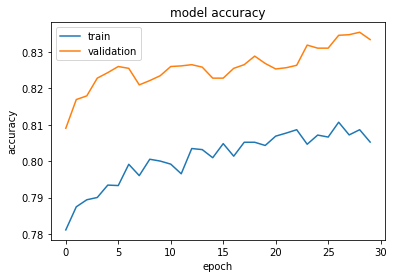

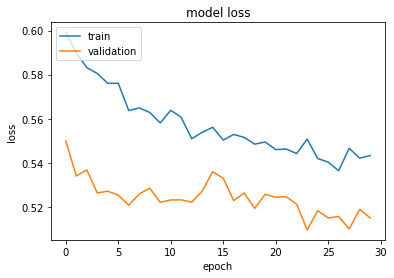

In [306]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [307]:
score = best_model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

233/233 [==============================] - 1s 4ms/step - loss: 0.5387 - accuracy: 0.8367
Test Loss: 0.5386731028556824
Test Accuracy: 0.8367429375648499


## Final Result

1. The Random forest model acieved accuracy of **0.82**
2. Compared to the Random Forest, the untuned deep learning models did not perform very well. Only the FCNN with dropout and the Bidirectional LSTM achieved accuracy score of **0.75**
3. We then tuned the hyperparameters of the FCNN with dropot model and as expected it achieved high accuracy score of **0.84**    

### Reference

1. For the TFIDF vectorizer we used the code from  a notbook shared by our professor last semester. And we implemented the Random Forest classifier ourselves
2. For the deep learning we used the GloVe embedding and FCNN code from a notebook shared by our professor on DL-1 course. But we added the other models and the Keras Tuning code by ourslves